In [26]:
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from hydra.utils import instantiate

from icicl.utils.experiment_utils import extract_config
from icicl.data.on_off_grid import OOTGBatch, SyntheticOOTGGenerator
from icicl.data.gp import RandomScaleGPGenerator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Trying OOTG Batches!

In [30]:
OOTGGen = SyntheticOOTGGenerator(
    off_grid_generator=RandomScaleGPGenerator(
        dim=1, 
        kernel_type= "eq", min_log10_lengthscale= -0.602, max_log10_lengthscale= 0.602, noise_std= 0.2,
        out_dim=2,
        min_num_ctx = 1, max_num_ctx = 64, min_num_trg = 128, max_num_trg = 128,
        context_range = [[-2.0, 2.0]],
        target_range = [[-3.0, 3.0]],
        samples_per_epoch = 16384,
        batch_size = 16
    ),
    grid_range=[[-3.0, 3.0]],
    points_per_unit=32,
    samples_per_epoch = 16000,
    batch_size = 16,
)

In [31]:
for batch in OOTGGen:
    print(batch.xc_on_grid.shape)
    print(batch.yc_on_grid.shape)
    print(batch.yc_off_grid.shape)
    print(batch.xt.shape)
    break

torch.Size([16, 257, 1])
torch.Size([16, 257, 1])
torch.Size([16, 1, 1])
torch.Size([16, 128, 1])


In [32]:
from icicl.models.ootg_tnp import OOTGSetConvEncoder
from icicl.utils.helpers import preprocess_observations
from icicl.utils.conv import flatten_grid, unflatten_grid
from icicl.networks.mlp import MLP

grid_encoder = OOTGSetConvEncoder(dim=1, init_lengthscale=2 * 1 / 4)
xy_encoder = MLP(in_dim= 3 + 1, out_dim = 5, num_layers = 2, width= 32)

patch_size = 16
conv = torch.nn.Conv1d(in_channels=5, out_channels=5, kernel_size=patch_size, stride=patch_size)

def coarsen_grid(z: torch.Tensor) -> torch.Tensor:
        
        # z will be of shape (batch, num_on_grid, embed_dim)
        z = unflatten_grid(z, dim=1)
        # move 'channels' (i.e embed_dim) right after batch
        z = z.movedim(-1, 1)
        z = conv(z)
        # move 'channels' (i.e embed_dim) to end again
        z = z.movedim(1, -1)
        return flatten_grid(z)

for batch in OOTGGen:
    xc, yc = grid_encoder(xc_off_grid=batch.xc_off_grid, yc_off_grid=batch.yc_off_grid, xc_on_grid=batch.xc_on_grid, yc_on_grid=batch.yc_on_grid)

    yc, yt = preprocess_observations(batch.xt, yc)
    print(yc.shape)
    zc = torch.cat((xc, yc), dim=-1)
    print(zc.shape)
    # So zc is 3 + xdim
    zc = xy_encoder(zc)
    print(zc.shape)
    zc = coarsen_grid(zc)  
    print(zc.shape) 

    zt = torch.cat((batch.xt, yt), dim=-1)
    zt = xy_encoder(zt)
    print(zt.shape)
    break

torch.Size([16, 257, 3])
torch.Size([16, 257, 4])
torch.Size([16, 257, 5])
torch.Size([16, 16, 5])
torch.Size([16, 128, 5])


# Profiling

In [77]:
#config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_vit.yml", [])
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

Global seed set to 0
Global seed set to 0


0

In [85]:
from icicl.utils.experiment_utils import np_loss_fn
import time

model = experiment.model
gen_train = experiment.generators.train
grid_encoder = OOTGSetConvEncoder(dim=1, init_lengthscale=2 * 1 / 4)

start = time.time()
for i, batch in enumerate(gen_train):
    #grid_encoder(batch.xc_off_grid, batch.yc_off_grid, batch.xc_on_grid, batch.yc_on_grid)
    #np_loss_fn(model, batch)
    
    if i > 100:
        break

print(f"This took {time.time() - start} seconds")

This took 14.630586385726929 seconds


# ConvSet TNP Encoder Tests

In [2]:
from icicl.utils.conv import make_grid, flatten_grid, unflatten_grid
import torch 
import math
import einops

grid_range = torch.as_tensor([[-3.0, 3.0], [-4.0, 4.0]])
print(grid_range)

batch_shape = torch.Size((2,))


grid = make_grid(
    xmin = grid_range[:, 0].repeat(*batch_shape, 1), 
    xmax = grid_range[:, 1].repeat(*batch_shape, 1), 
    points_per_unit = 4, 
    margin = 0)

print(grid.shape)



plat = flatten_grid(grid)

onplat = unflatten_grid(plat)


torch.allclose(grid, onplat)


tensor([[-3.,  3.],
        [-4.,  4.]])
torch.Size([2, 33, 33, 2])


True

# Trying out stuff

In [37]:
import gpytorch
import torch

mean = gpytorch.means.ZeroMean()
kernel = gpytorch.kernels.RBFKernel()

mean(torch.randn(2, 10, 1)).shape

torch.Size([2, 10])

# Getting the true log-likelihood

In [46]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import lightning.pytorch as pl
from hydra.utils import instantiate
from experiments.plot import plot
from icicl.utils.experiment_utils import extract_config

config, config_dict = extract_config("experiments/configs/thesis/ootg_gp_conv_encoder_tnp.yml", [])
config["generators"]["val"]["samples_per_epoch"] = 16
config["generators"]["off_grid_generator_val"]["num_tasks"] = 2 # TODO change
config["generators"]["off_grid_generator_val"]["task_correlation"] = 0.7
pl.seed_everything(config.misc.seed)
experiment = instantiate(config)
pl.seed_everything(experiment.misc.seed)

batches = []
for batch in tqdm(experiment.generators.val, total=len(experiment.generators.val), desc="Validation"):
        batches.append(batch)


Global seed set to 0
Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.65it/s]


In [47]:
print(batches[0].xc.shape, batches[0].yc.shape, batches[0].xt.shape, batches[0].yt.shape)

torch.Size([16, 110, 1]) torch.Size([16, 110, 1]) torch.Size([16, 128, 1]) torch.Size([16, 128, 1])


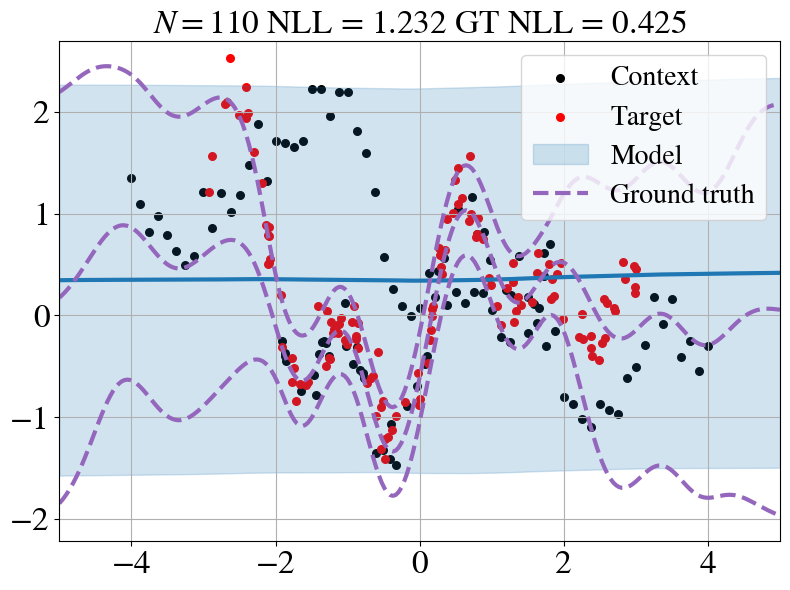

In [55]:
plot(model=experiment.model, batches=batches, num_fig=1)

# Trying attention mask encoder

In [1]:
%load_ext autoreload
%autoreload 2

import torch

from icicl.networks.attention_layers import MultiHeadCrossAttentionLayer
from icicl.networks.transformer import TNPDTransformerEncoder

emb_dim = 5
mhca_layer = MultiHeadCrossAttentionLayer(embed_dim=emb_dim, num_heads=2, head_dim=3, feedforward_dim=emb_dim)
encoder = TNPDTransformerEncoder(num_layers=2, mhca_layer=mhca_layer)

a = torch.randn(2, 4, emb_dim)
b = torch.randn(2, 3, emb_dim)
single = torch.randn(emb_dim)

encoder(a, b).shape

torch.Size([2, 3, 5])

In [9]:
# natively find idx's:
for idx,batch in enumerate(b):
    for vec in batch:
        beste = (a[idx] - vec).abs().sum(dim=-1).argmin()
        print(f"batch{idx}: {beste}")

batch0: 2
batch0: 2
batch0: 2
batch1: 1
batch1: 0
batch1: 3


In [14]:
ap = a.repeat(b.shape[-2],1, 1, 1).movedim(0,1)
bp = b.repeat(a.shape[-2],1, 1, 1).movedim(0,2)


idx = (bp - ap).abs().sum(dim=-1).argmin(dim=2)
print(idx)
batch_idx = torch.arange(idx.shape[0]).repeat_interleave(idx.shape[-1])
a_idx = torch.arange(idx.shape[-1]).repeat(idx.shape[0])

mask = torch.zeros(*b.shape[:2], a.shape[-2])
mask[batch_idx, a_idx, idx.flatten()] = 1
mask


tensor([[2, 2, 2],
        [1, 0, 3]])


tensor([[[0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.]],

        [[0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]])

In [8]:
encoder(a, b, mask).shape

torch.Size([2, 3, 5])